In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import pickle
from himalaya.backend import set_backend, get_backend
import gc
from sklearn.decomposition import PCA
import utils
set_backend("torch_cuda")
from himalaya.ridge import GroupRidgeCV, ColumnTransformerNoStack, RidgeCV
from himalaya.scoring import r2_score_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import check_cv
from sklearn.utils import check_random_state
import torch
from strfpy import findDatasets, preprocSound
from strfpy.calcSegmentedModel import arbitrary_kernel, generate_laguerre_features
# Configure PyTorch to be memory efficient
torch.cuda.empty_cache()
# Check backend
print(get_backend())

<module 'himalaya.backend.torch_cuda' from '/nfs/zdrive/sjshim/code/himalaya/himalaya/backend/torch_cuda.py'>


In [2]:
def get_conv_kernel_input(data_dict, nPoints, resp_key="lfp_downsampled_demeaned", 
                        event_key = "onoff_feature", word_buffer = 0):
    '''
    Create convolved kernel X and response Y for a given dataset

    Parameters
    ----------
    data_dict : dict
        Dictionary containing the dataset
    nPoints : int
        Number of points to use for the kernel
    resp_key : str
        Key in data_dict containing the response
    event_key : 
        Key in data_dict containing the event
    word_buffer : int
        Buffer time in seconds to consider before word onset

    Returns
    -------
    X : np.array
        Convolved kernel
    Y : np.array
        Response
    sentence_boundaries : np.array
        Index of sentence boundaries
    '''
    print(f"Processing data for {resp_key}_{nPoints}")
    X = None
    Y = None
    Y_list = []

    if event_key == "onoff_feature":
        event_index_key = "index"
        buffered_event_index_key = "index_word-buffered"
    # data_dict, buffered_event_index_key = utils.add_word_buffer(data_dict, event_index_key, word_buffer)
    
    for key in data_dict.keys():
        batch_x = arbitrary_kernel(data_dict[key], nPoints=nPoints, event_key=event_key, 
                                event_index_key=buffered_event_index_key, resp_key=resp_key)
        batch_y = data_dict[key]['resp'][f"{resp_key}"]
        Y_list.extend([batch_y])
        if X is None:
            X = batch_x
        else:
            X = np.hstack([X, batch_x])
        
        if Y is None:
            Y = batch_y
        else:
            Y = np.hstack([Y, batch_y])
        
    sentence_boundaries = np.cumsum([len(y) for y in Y_list])

    return X, Y, sentence_boundaries

In [3]:
def create_kernel_and_fit(
    model_file_path, resp_key, event_key, nPoints, 
    word_buffer, data_dict, rerun_model=False
):
    if (not os.path.exists(model_file_path)) or rerun_model:
        print(f"Computing new kernel for {resp_key}_{nPoints}")

        X, Y, sentence_boundaries = get_conv_kernel_input(
            data_dict, nPoints, resp_key=resp_key, 
            event_key=event_key, word_buffer=word_buffer
        )

        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        
        # Clear GPU memory before fitting
        torch.cuda.empty_cache()
        alphas = np.logspace(-2, 5, 10)
        model = RidgeCV(
            alphas=alphas,
            fit_intercept=True,
            solver_params={
                "n_targets_batch": 10,
                "n_alphas_batch": 5,
            },
        )
        model.fit(X.T, Y)
        gc.collect()
        torch.cuda.empty_cache()

        # Save model to file
        with open(model_file_path, "wb") as f:
            pickle.dump(model, f)

    else:
        print(f"Loading model from {model_file_path}")
        with open(model_file_path, "rb") as f:
            model = pickle.load(f)

    return model


In [4]:
def plot_learned_kernel(learned_conv_kernel, word_buffer, plot_file):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    ax[0].plot(learned_conv_kernel[0])
    ax[0].set_title("Onset Kernel")
    ax[1].plot(learned_conv_kernel[1])
    ax[1].set_title("Offset Kernel")

    for i in range(2):
        ax[i].axvline(word_buffer*100, color="k", linestyle="--", alpha=0.5)
    plt.savefig(plot_file)

In [5]:
def plot_prediction_vs_actual(model, nPoints, event_key, resp_key, data_dict, save_file_name):
    """
    Plot a segment of the prediction vs actual neural response during events of random sentence.
    """
    # Randomly select 2 consecutive data_dict key
    keys = list(data_dict.keys())
    random_key = np.random.choice(keys)
    x = arbitrary_kernel(data_dict[random_key], nPoints=nPoints, event_key=event_key, resp_key=resp_key)
    y = data_dict[random_key]["resp"][f"{resp_key}"]
    coef = model.coef_
    if torch.is_tensor(coef):
        coef = coef.cpu().numpy()
    yhat = model.predict(x.T)

    # Print the R^2 score
    r2 = model.score(x.T, y)
    print(f"R^2 Score: {r2}")
    
    plt.figure(figsize=(12, 6))
    # Plot onsets of events
    event_idx = data_dict[random_key]["events"]["index"]
    plt.plot(y, label="Actual Response")
    plt.plot(yhat, label="Predicted Response")
    for idx in event_idx:
        plt.axvline(idx, color="k", linestyle="--", alpha=0.5)
    plt.legend()
    plt.title(f"Predicted vs Actual Neural Response Sentence {random_key}")
    plt.savefig(save_file_name)
    plt.show()
    plt.close()


In [6]:
def process_and_save_kernels(
    config,
    train_test_split=False,
    test_size=0.2,
    rerun_model=False
):
    """
    Process and save kernels using memory-efficient batching.
    """

    base_dir, sub_num, electrode_num, resp_key, event_key, nPoints, word_buffer, chunk_buffer, subset_value = config.values()

    if train_test_split:
        train_data_dict_path = utils.generate_multiple_feature_file_name(**config, save_item="train_data_dict")
        test_data_dict_path = utils.generate_multiple_feature_file_name(**config, save_item="test_data_dict")
        train_data_dict, test_data_dict = utils.load_or_create_data_dict_train_test(
            train_data_dict_path,
            test_data_dict_path,
            sub_num,
            electrode_num,
            chunk_buffer,
            word_buffer,
            subset_value,
            train_test_split=train_test_split,
            test_size=test_size,
            rerun_model=rerun_model
        )
        model_file_path = utils.generate_multiple_feature_file_name(**config, save_item="model")
        model = create_kernel_and_fit(
            model_file_path, resp_key, event_key, nPoints, word_buffer, 
            train_data_dict, rerun_model=rerun_model
        )
        prediction_plot_file_path = utils.generate_multiple_feature_file_name(**config, save_item="prediction_plot", extension="png")
        plot_prediction_vs_actual(model, nPoints, event_key, resp_key, test_data_dict, prediction_plot_file_path)

        learned_conv_kernel = model.coef_.reshape(2, nPoints)
        plot_file = utils.generate_multiple_feature_file_name(**config, save_item="learned_conv_kernel", extension="png")
        plot_learned_kernel(learned_conv_kernel, word_buffer, plot_file)

    else:
        data_dict_path = utils.generate_multiple_feature_file_name(**config, save_item="data_dict")
        data_dict = utils.load_or_create_data_dict(
            data_dict_path,
            sub_num,
            electrode_num,
            chunk_buffer,
            word_buffer,
            subset_value,
            rerun_model=rerun_model
        )
        model_file_path = utils.generate_multiple_feature_file_name(**config, save_item="model")
        model = create_kernel_and_fit(
            model_file_path, resp_key, event_key, nPoints, word_buffer, 
            data_dict, rerun_model=rerun_model
        )

        prediction_plot_file_path = utils.generate_multiple_feature_file_name(**config, save_item="prediction_plot", extension="png")
        plot_prediction_vs_actual(model, nPoints, event_key, resp_key, data_dict, prediction_plot_file_path)
        
        learned_conv_kernel = model.coef_.reshape(2, nPoints)
        plot_file = utils.generate_multiple_feature_file_name(**config, save_item="learned_conv_kernel", extension="png")
        plot_learned_kernel(learned_conv_kernel, word_buffer, plot_file)


    return model, learned_conv_kernel

In [7]:
# run subset
base_dir = '/nfs/zdrive/sjshim/code/brain_treebank_analysis'
sub_id = 3
electrode_num = 69
nPoints = 120
word_buffer = 0.2
subset_value = None
chunk_buffer = 1

config = {
    "base_dir": base_dir,
    "sub_num": sub_id,
    "electrode_num": electrode_num,
    "resp_key": "lowpassed_downsampled_demeaned",
    "event_key": "onoff_feature",
    "nPoints": nPoints,
    "word_buffer": word_buffer,
    "chunk_buffer": chunk_buffer,
    "subset_value": subset_value,
}


no subset
Number of words in test set: 2035
Computing new kernel for lowpassed_downsampled_demeaned_120
Processing data for lowpassed_downsampled_demeaned_120
R^2 Score: -0.02852809429168701


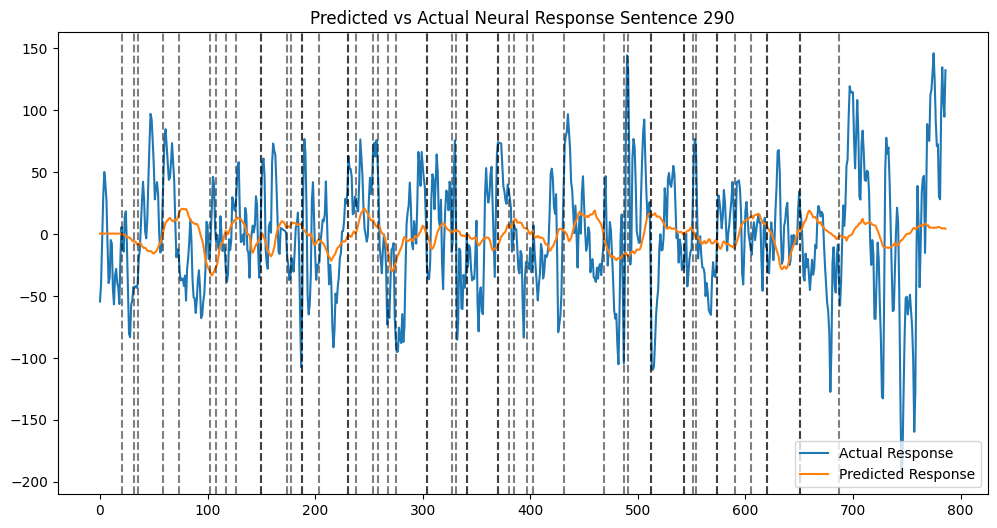

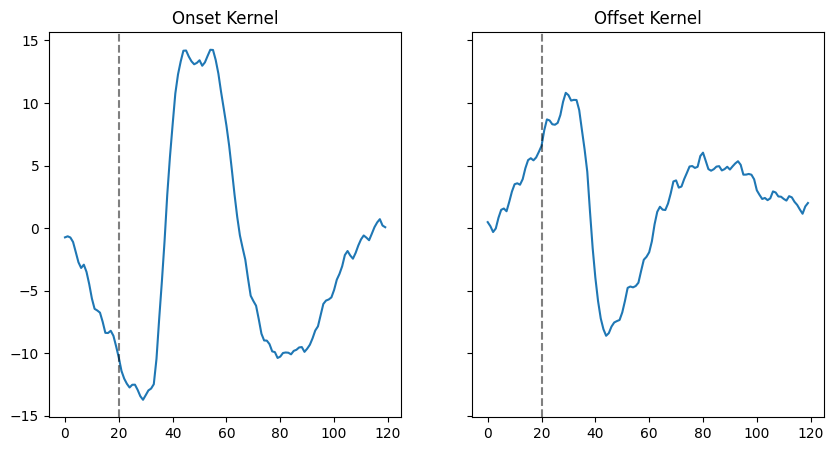

In [8]:
model, learned_conv_kernel = process_and_save_kernels(config, train_test_split=True, test_size=0.2, rerun_model=True)

In [10]:
test_data_dict_path = utils.generate_multiple_feature_file_name(**config, save_item="test_data_dict")
test_data_dict = utils.load_or_create_data_dict(
    test_data_dict_path,
    sub_id,
    electrode_num,
    chunk_buffer,
    word_buffer,
    subset_value,
    rerun_model=False
)
X_test, Y_test, chunk_boundaries_test = get_conv_kernel_input(
    test_data_dict, nPoints, resp_key="lowpassed_downsampled_demeaned", event_key="onoff_feature", word_buffer=word_buffer
)
R2_onset_offset = model.score(X_test.T, Y_test)
R2_onset_offset

no subset
loading existing data_dict
Processing data for lowpassed_downsampled_demeaned_120


tensor(0.0454, device='cuda:0')

In [11]:
def spect_PCA(data_dict, n_components=20):
    nEventTypes = 2
    mel_values = None
    for k in data_dict.keys():
        mel = data_dict[k]['stim']['mel']
        if mel_values is None:
            mel_values = mel
        else:
            mel_values = np.vstack([mel_values, mel])
    
    pca = PCA(n_components=n_components)
    mel_values = StandardScaler().fit_transform(mel_values)
    pca.fit(mel_values)

    for k in data_dict.keys():
        events = data_dict[k]['events']['onoff_feature']
        n_events = len(data_dict[k]['events']['index'])
        mel_pca_features = pca.transform(data_dict[k]['stim']['mel_aligned'])
        data_dict[k]['events']['pca_mel'] = np.zeros((n_events, nEventTypes*n_components))
        for iEventType in range(events.shape[1]):
            data_dict[k]['events']['pca_mel'][events[:,iEventType]==1,iEventType*n_components:(iEventType+1)*n_components] = mel_pca_features[events[:,iEventType]==1,:]

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].plot(np.cumsum(pca.explained_variance_ratio_))
    ax[0].set_title('Explained Variance')
    ax[0].set_xlabel('PC')
    ax[0].set_ylabel('Cumulative Explained Variance')
    pc_ind = np.random.randint(0, n_components, 1)
    ax[1].imshow(pca.components_[pc_ind].reshape((1,128)), aspect='auto', origin='lower', cmap='inferno')
    ax[1].set_title('PC %d'%pc_ind)



In [12]:
def convert_speaker_labels(data_dict, speaker_mapping_file_path, test_data_dict=None):
    label_encoder = LabelEncoder()

    # Collect all speaker names from both data_dict and test_data_dict if provided
    all_speakers = []
    for k in data_dict.keys():
        all_speakers.extend(data_dict[k]['stim']['speaker'])
    
    if test_data_dict is not None:
        for k in test_data_dict.keys():
            all_speakers.extend(test_data_dict[k]['stim']['speaker'])

    label_encoder.fit(all_speakers)

    # Transform the speaker names to numerical values and save the mapping
    speaker_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # Print the mapping
    print("Speaker Mapping:")
    for speaker, num in speaker_mapping.items():
        print(f"{speaker}: {num}")

    # Save the mapping to a file
    with open(speaker_mapping_file_path, 'wb') as f:
        pickle.dump(speaker_mapping, f)

    # Apply the transformation to the data_dict
    for k in data_dict.keys():
        data_dict[k]['stim']['speaker_label'] = label_encoder.transform(data_dict[k]['stim']['speaker'])

    # Apply the transformation to the test_data_dict if provided
    if test_data_dict is not None:
        for k in test_data_dict.keys():
            test_data_dict[k]['stim']['speaker_label'] = label_encoder.transform(test_data_dict[k]['stim']['speaker'])
        return data_dict, test_data_dict, speaker_mapping
    else:
        return data_dict, speaker_mapping

In [13]:
words_file = '/nfs/zdrive/sjshim/brain_treebank_data/sub_3_trial000_words.csv'
import pandas as pd
df = pd.read_csv(words_file)

# Count top 10 most frequent speakers
speakers = df['speaker']

In [14]:
# Add top 10 most frequent speakers to top_speakers list
top_speakers = speakers.value_counts().index[:10].tolist()

In [15]:
top_speakers

['Mater',
 'Lightning McQueen',
 'Finn McMissile',
 'Holly Shiftwell',
 'Brent Mustangburger',
 'Francesco Bernoulli',
 'Miles Axlerod',
 'Professor Zündapp',
 'Darrell Cartrip',
 'David Hobbscap']

In [22]:
train_data_dict_path = utils.generate_multiple_feature_file_name(**config, save_item="train_data_dict")
test_data_dict_path = utils.generate_multiple_feature_file_name(**config, save_item="test_data_dict")

train_data_dict = utils.load_or_create_data_dict(train_data_dict_path, sub_id, electrode_num, chunk_buffer, word_buffer, subset_value, rerun_model=False)
test_data_dict = utils.load_or_create_data_dict(test_data_dict_path, sub_id, electrode_num, chunk_buffer, word_buffer, subset_value, rerun_model=False)

no subset
loading existing data_dict
no subset
loading existing data_dict


/tmp/ipykernel_2339883/4152216228.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[1].set_title('PC %d'%pc_ind)
/tmp/ipykernel_2339883/4152216228.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[1].set_title('PC %d'%pc_ind)


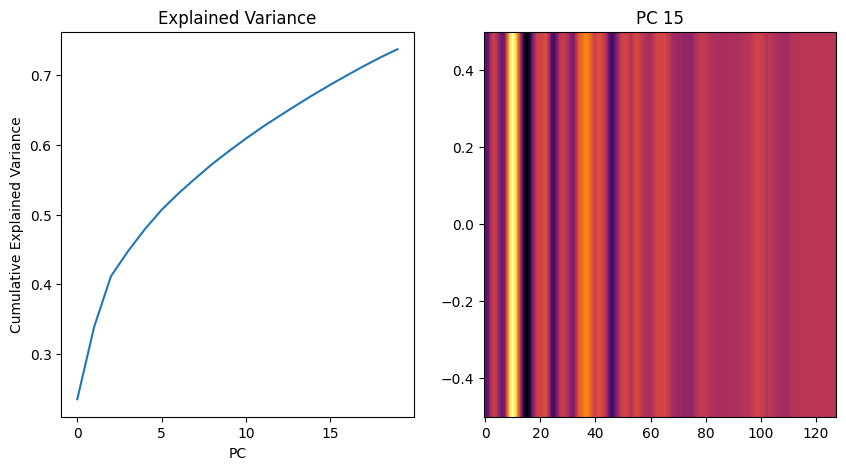

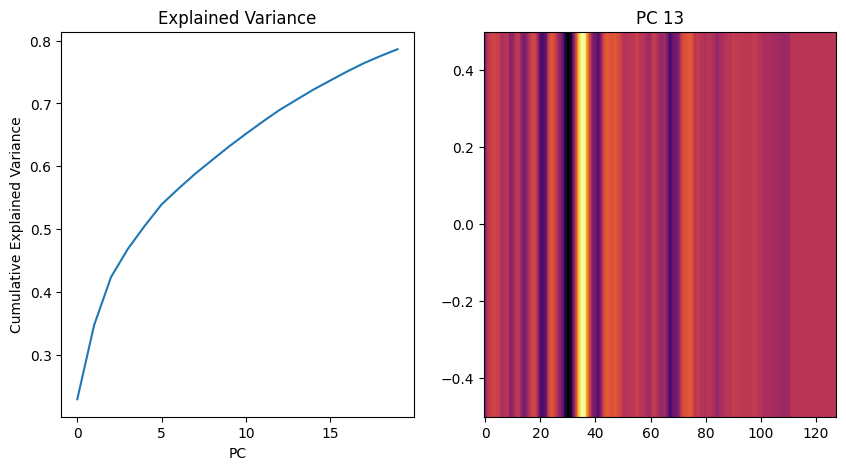

In [16]:
spect_PCA(train_data_dict, n_components=20)
spect_PCA(test_data_dict, n_components=20)

In [17]:
speaker_mapping_file_path = utils.generate_multiple_feature_file_name(**config, save_item="speaker_mapping")
train_data_dict, test_data_dict, speaker_mapping_dict = convert_speaker_labels(train_data_dict, speaker_mapping_file_path, test_data_dict=test_data_dict)

Speaker Mapping:
(various cars in the pit): 0
* multiple speakers: 1
* not in audio: 2
Acer: 3
Acer * Grem: 4
Alexander Hugo: 5
Aunt Topolino: 6
Brent Mustangburger: 7
Crabby: 8
Darrell Cartrip: 9
David Hobbscap: 10
Filmore: 11
Finn McMissile: 12
Fio: 13
Flo: 14
Francesco Bernoulli: 15
Grem: 16
Grem * Acer: 17
Guido: 18
Holly Shiftwell: 19
Holly Shiftwell * Finn MicMissile: 20
Ivan the towtruck: 21
J. Curby Gremlin: 22
Jeff Gorvette: 23
Leland Turbo: 24
Lewis Hamilton: 25
Lightning McQueen: 26
Lightning McQueen (reading letter): 27
Lightning McQueen * Francesco Bernoulli: 28
Lizzie: 29
Luigi: 30
Luigi (reading): 31
Ma: 32
Mack: 33
Mat: 34
Mater: 35
Mater (letter): 36
Mel Dorado: 37
Miles Axlerod: 38
Minny: 39
Otis: 40
Professor Zündapp: 41
Ramone: 42
Rod Redline: 43
Sally: 44
Sarge: 45
Sheriff: 46
Siddeley: 47
Stephenson: 48
Tannoy: 49
Tomber: 50
Tony: 51
Tubbs Pacer: 52
Uncle Topolino: 53
Van: 54
Victor Hugo: 55
Vladimir Trunkov: 56
announcer: 57
british corporal: 58
british police ca

In [18]:
# From speaker_mapping_dict, get the top 10 speakers mapping
top_speakers_mapping = [speaker_mapping_dict[speaker] for speaker in top_speakers]

In [19]:
speaker_values = speaker_mapping_dict.values()

In [20]:
def add_speaker_event_labels(data_dict, speaker_values, top_speakers_mapping):
    for k in data_dict.keys():
        # Initialize speaker event labels with top_speakers_mapping
        for top_speaker in top_speakers_mapping:
            data_dict[k]['stim'][f'speaker_{top_speaker}'] = np.zeros(len(data_dict[k]['events']['on_index']))
        
        # Add speaker event label for all other speakers
        data_dict[k]['stim']['speaker_rest'] = np.zeros(len(data_dict[k]['events']['on_index']))
        
        for i, event_idx in enumerate(data_dict[k]['events']['on_index']):
            speaker_label = data_dict[k]['stim']['speaker_label'][i]
            if speaker_label in top_speakers_mapping:
                data_dict[k]['stim'][f'speaker_{speaker_label}'][i] = 1
            else:
                data_dict[k]['stim']['speaker_rest'][i] = 1
    
    return data_dict

In [21]:
train_data_dict = add_speaker_event_labels(train_data_dict, speaker_values, top_speakers_mapping)
test_data_dict = add_speaker_event_labels(test_data_dict, speaker_values, top_speakers_mapping)

In [23]:
def add_sentence_position_labels(data_dict):
    '''
    Add sentence position labels to data_dict
    0: first word
    1: second word
    2: third word
    3: second to last word
    4: third to last word
    5: last word
    '''
    for key in data_dict.keys():
        stim_data = data_dict[key]['stim']
        
        sentence_indices = stim_data['sentence_idx']
        idx_in_sentence = stim_data['idx_in_sentence']
        
        position_labels = np.zeros_like(idx_in_sentence)
        
        unique_sentences = np.unique(sentence_indices)
        
        for sentence in unique_sentences:
            sentence_mask = sentence_indices == sentence
            max_idx = np.max(idx_in_sentence[sentence_mask])
            
            if max_idx >= 0:
                position_labels[sentence_mask & (idx_in_sentence == 0)] = 0
            if max_idx >= 1:
                position_labels[sentence_mask & (idx_in_sentence == max_idx)] = 5
            if max_idx >= 2:
                position_labels[sentence_mask & (idx_in_sentence == 1)] = 1
            if max_idx >= 3:
                position_labels[sentence_mask & (idx_in_sentence == 2)] = 2
            if max_idx >= 4:
                position_labels[sentence_mask & (idx_in_sentence == max_idx-1)] = 3
            if max_idx >= 5:
                position_labels[sentence_mask & (idx_in_sentence == max_idx-2)] = 4
        
        stim_data['sentence_position'] = position_labels
    
    return data_dict

In [24]:
def add_sentence_position_events(data_dict):
    for k in data_dict.keys():
        data_dict[k]['stim']['sentence_position_0'] = np.zeros(len(data_dict[k]['events']['on_index']))
        data_dict[k]['stim']['sentence_position_1'] = np.zeros(len(data_dict[k]['events']['on_index']))
        data_dict[k]['stim']['sentence_position_2'] = np.zeros(len(data_dict[k]['events']['on_index']))
        data_dict[k]['stim']['sentence_position_3'] = np.zeros(len(data_dict[k]['events']['on_index']))
        data_dict[k]['stim']['sentence_position_4'] = np.zeros(len(data_dict[k]['events']['on_index']))
        data_dict[k]['stim']['sentence_position_5'] = np.zeros(len(data_dict[k]['events']['on_index']))
        
        for i, event_idx in enumerate(data_dict[k]['events']['on_index']):
            sentence_position = data_dict[k]['stim']['sentence_position'][i]
            data_dict[k]['stim'][f'sentence_position_{sentence_position}'][i] = 1

    return data_dict

In [25]:
train_data_dict = add_sentence_position_labels(train_data_dict)
test_data_dict = add_sentence_position_labels(test_data_dict)

train_data_dict = add_sentence_position_events(train_data_dict)
test_data_dict = add_sentence_position_events(test_data_dict)

In [26]:
train_data_dict[0]['stim']['sentence_position_5']

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [27]:
def add_features(data_dict, feature_keys):
    nEventTypes = 2
    for feature_key in feature_keys:
        for k in data_dict.keys():
            events = data_dict[k]['events']['onoff_feature']
            n_events = len(data_dict[k]['events']['index'])
            feature = data_dict[k]['stim'][feature_key]
            data_dict[k]['events'][feature_key] = np.zeros((n_events, nEventTypes))
            for iEventType in range(events.shape[1]):
                data_dict[k]['events'][feature_key][events[:,iEventType]==1, iEventType] = feature
    return data_dict
        

In [15]:
# make features
feature_keys = ['gpt2_surprisal', 'sentence_position_0', 'sentence_position_1', 'sentence_position_2', 'sentence_position_3', 'sentence_position_4', 'sentence_position_5']

In [28]:
feature_keys = ['sentence_position_0', 'sentence_position_1', 'sentence_position_2', 'sentence_position_3', 'sentence_position_4', 'sentence_position_5']

In [29]:
feature_keys

['sentence_position_0',
 'sentence_position_1',
 'sentence_position_2',
 'sentence_position_3',
 'sentence_position_4',
 'sentence_position_5']

In [30]:
train_data_dict = add_features(train_data_dict, feature_keys)
test_data_dict = add_features(test_data_dict, feature_keys)

In [18]:
from functools import partial
from strfpy.calcSegmentedModel import laguerre
nEventTypes = 2
print("Fitting laguerre parameters")
partial_laguerre = partial(laguerre, xorder=0)
def sum_n_laguerres(xt, *args):
    amp, tau, alpha, *w = args
    nL = len(w)
    out = np.zeros_like(xt,dtype=float)
    for iL in range(nL):
        out += w[iL] * laguerre(xt, amp, tau, alpha, xorder=iL) # TODO FIX
    return out

laguerre_args = np.zeros((nEventTypes,3))
all_args = np.zeros((nEventTypes,8))
for iEventType in range(nEventTypes):
    popt, pcov = curve_fit(sum_n_laguerres, np.arange(nPoints), learned_conv_kernel[iEventType,:], p0=[2, 6, 5,1,1,1,1,1], bounds=([ -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]), method='trf',max_nfev=10000)
    laguerre_args[iEventType,:] = popt[:3]
    all_args[iEventType,:] = popt

Fitting laguerre parameters


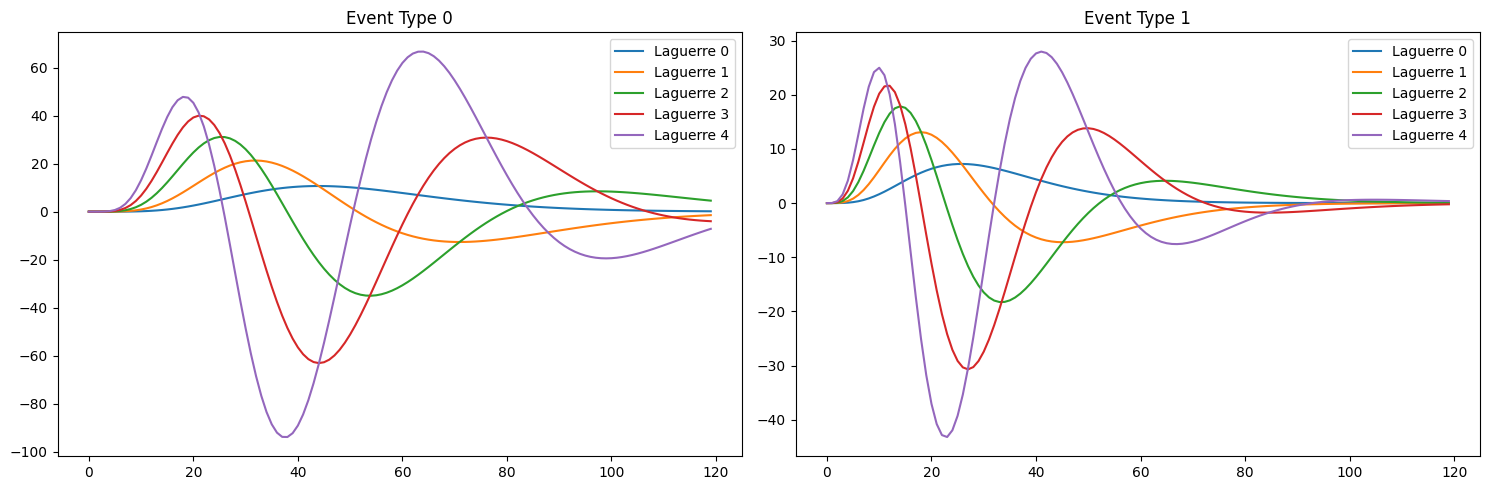

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for iEventType in range(nEventTypes):
    for i, w in enumerate(all_args[iEventType, 3:]):
        ax[iEventType].plot(laguerre(np.arange(nPoints), all_args[iEventType, 0], all_args[iEventType, 1], all_args[iEventType, 2], xorder=i), label=f'Laguerre {i}')
    ax[iEventType].set_title(f'Event Type {iEventType}')
    ax[iEventType].legend()

plt.tight_layout()
plt.show()

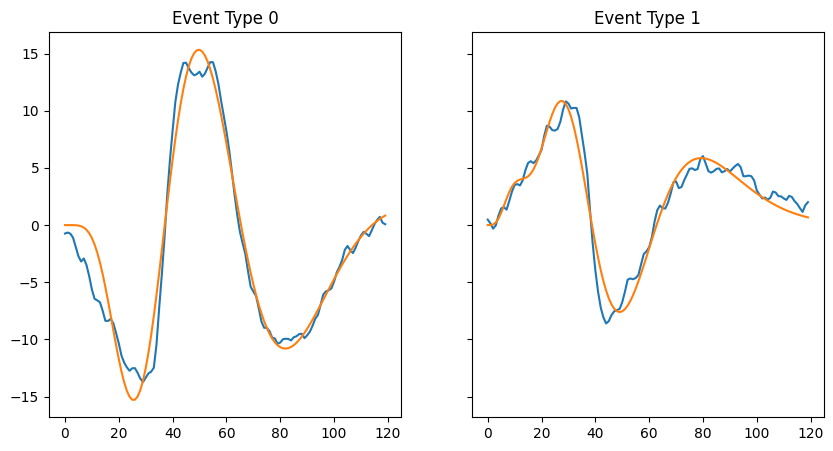

In [20]:
# Visualize how well laguerre functions were fit
fig, ax = plt.subplots(1,2, figsize=(10,5),sharey=True)
for iEventType in range(nEventTypes):
    ax[iEventType].plot(learned_conv_kernel[iEventType,:])
    ax[iEventType].plot(sum_n_laguerres(np.arange(nPoints), *all_args[iEventType,:]))
    ax[iEventType].set_title('Event Type %d'%iEventType)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


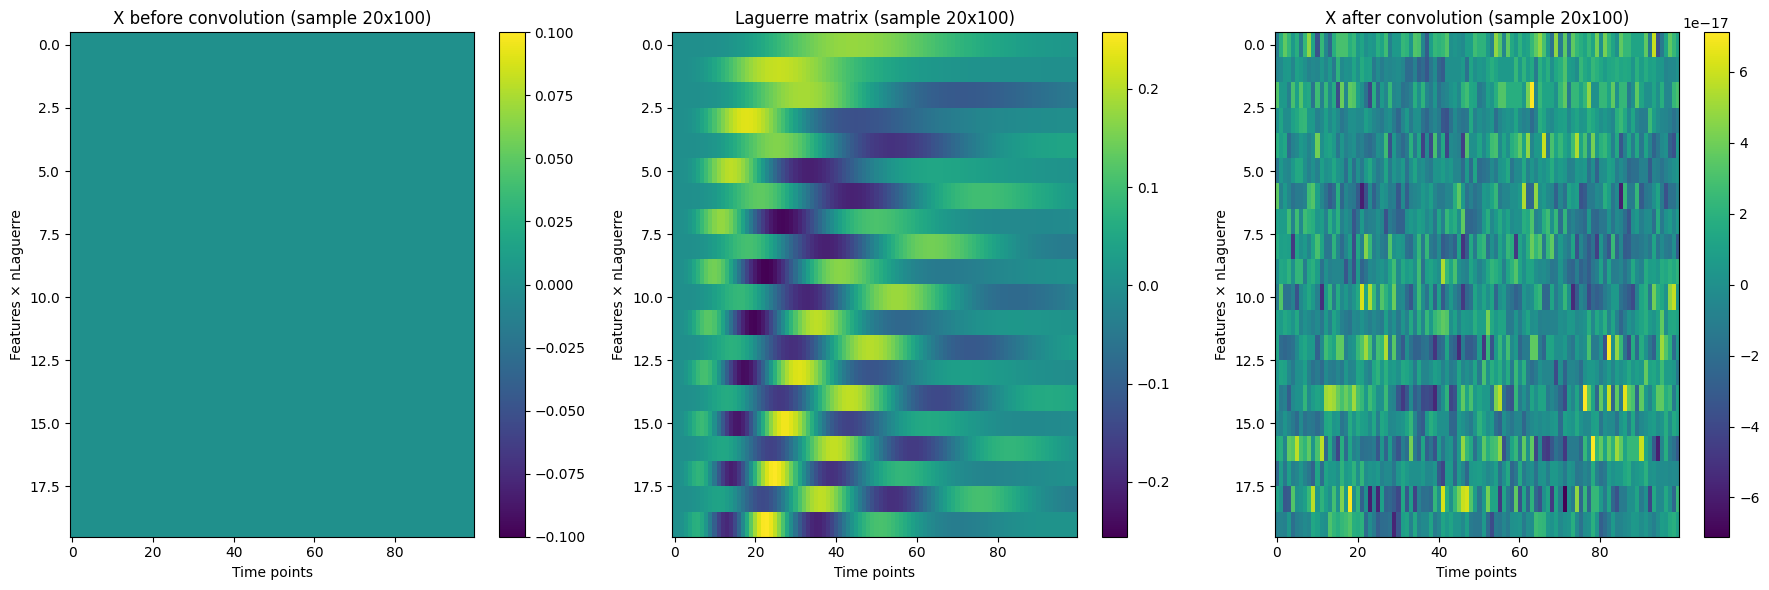

X before convolution shape: (20, 481)
Laguerre matrix shape: (20, 120)
X after convolution shape: (20, 481)


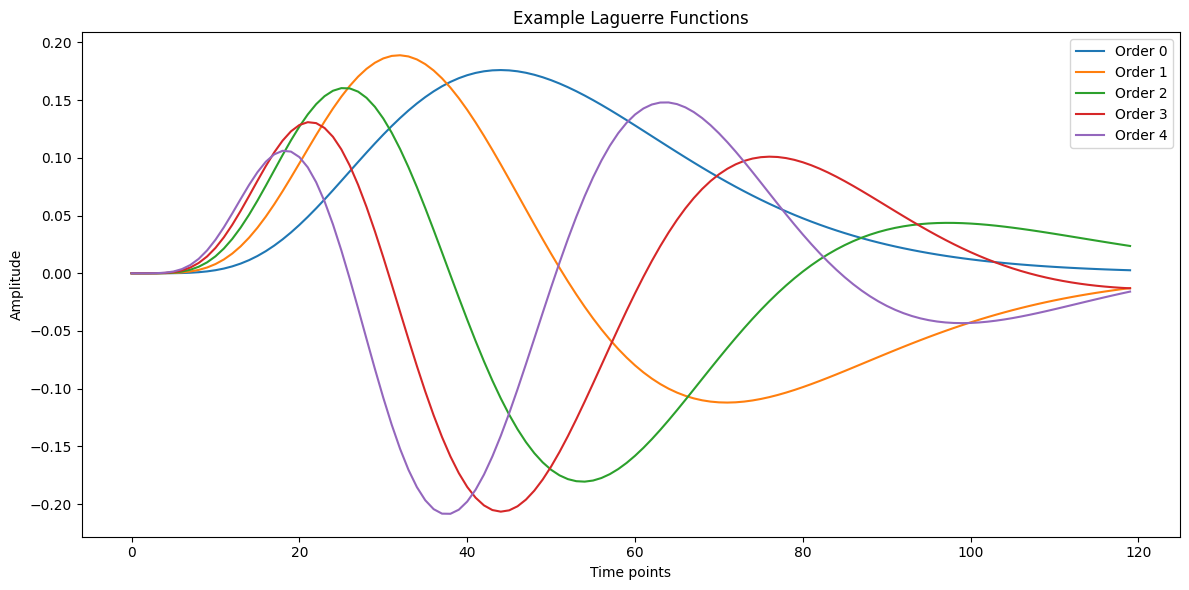

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


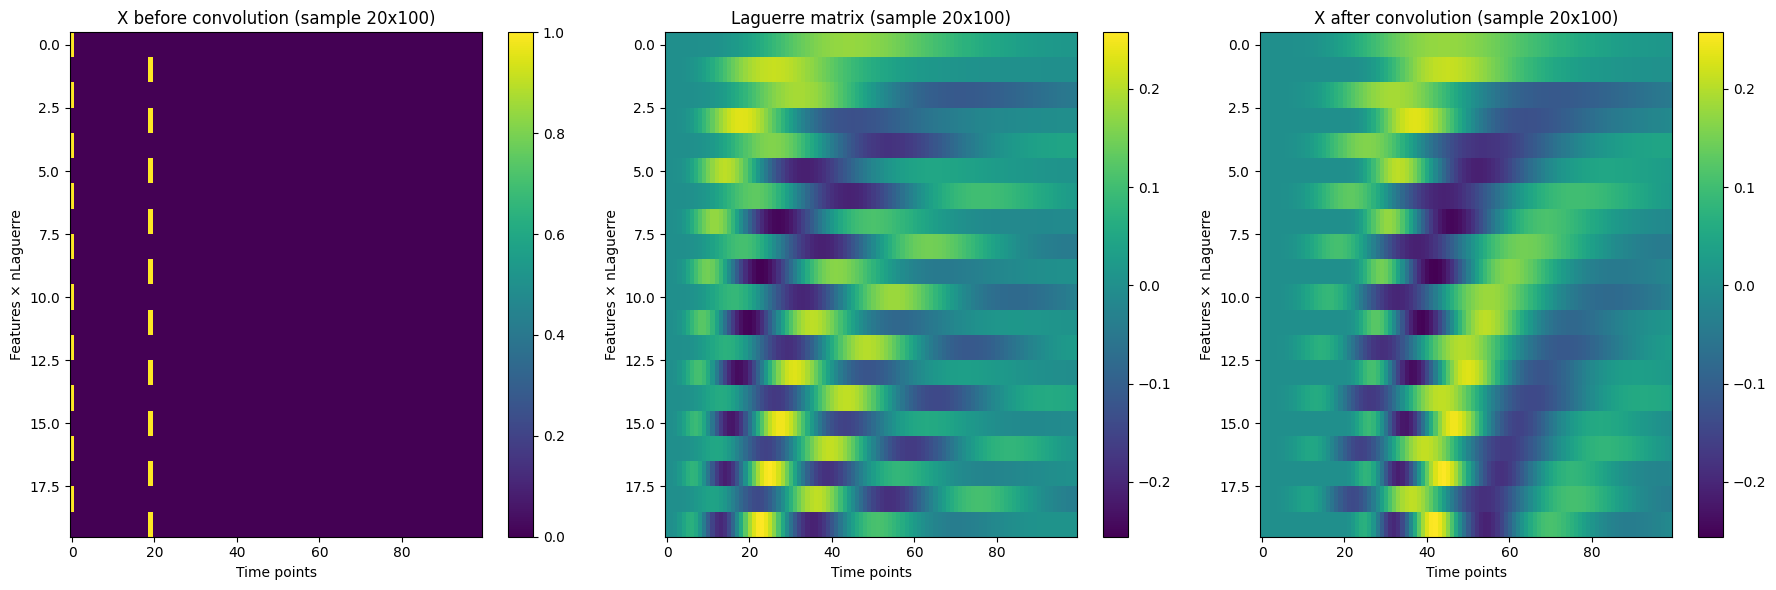

X before convolution shape: (20, 275)
Laguerre matrix shape: (20, 120)
X after convolution shape: (20, 275)


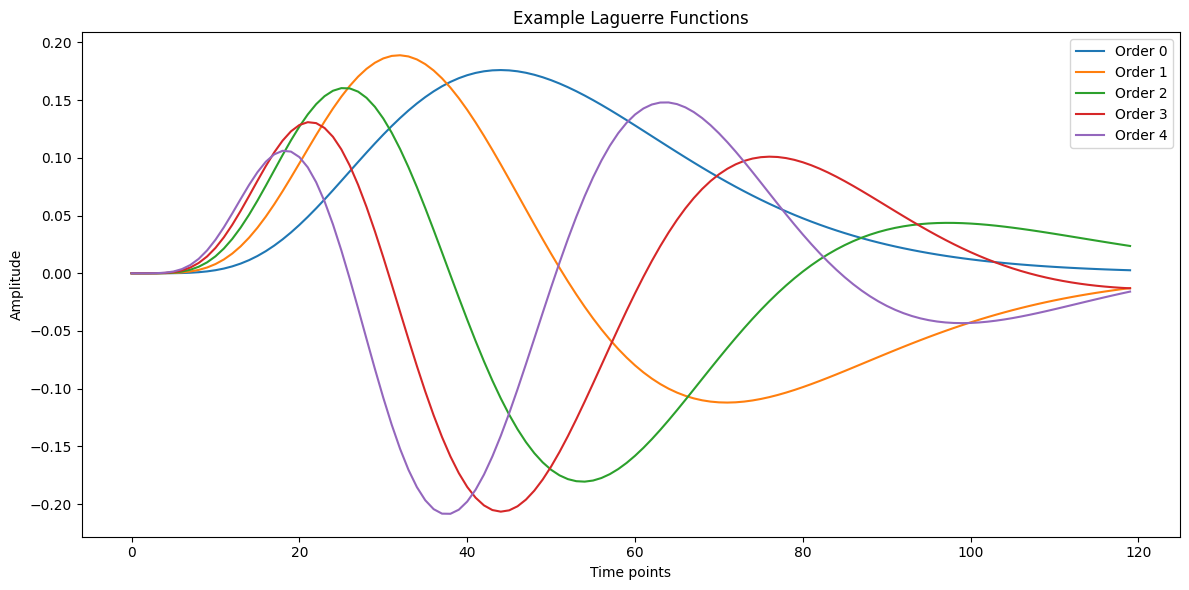

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


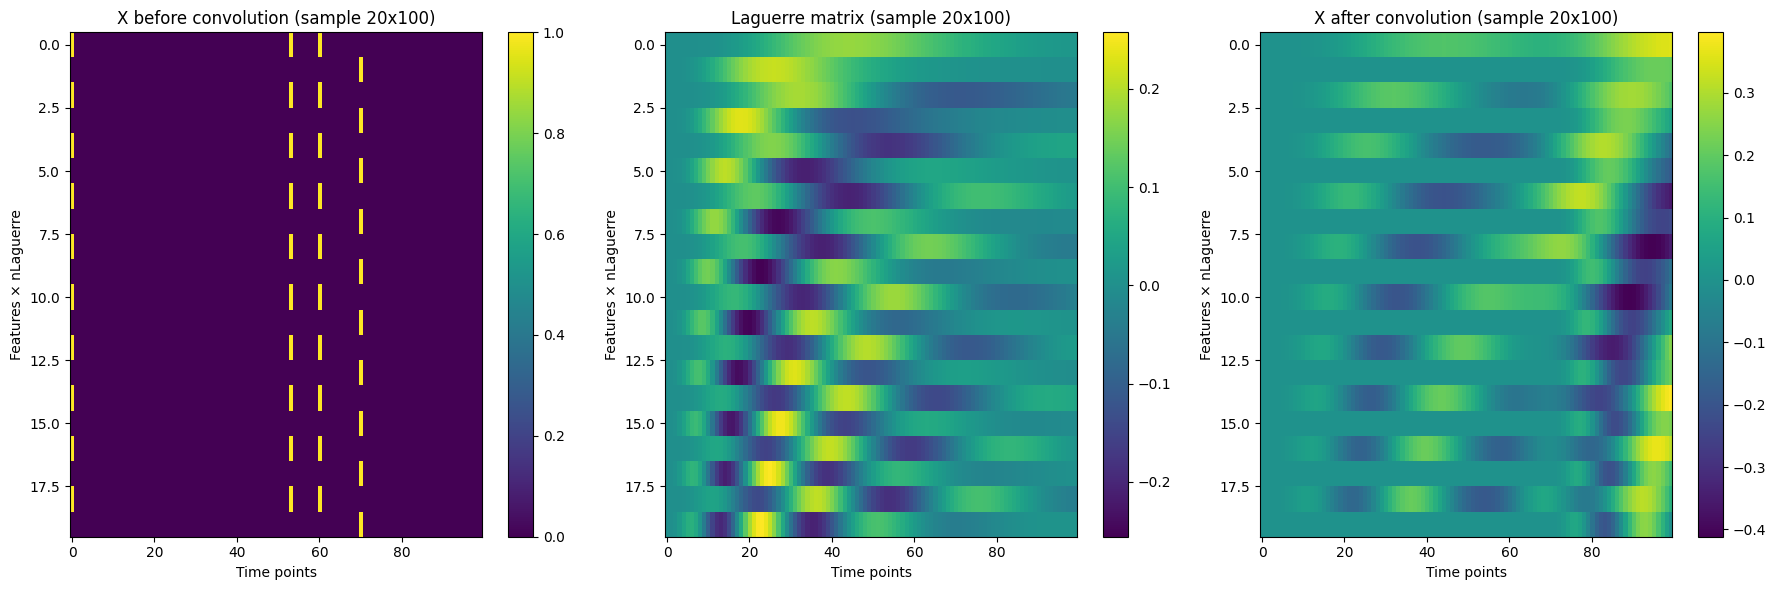

X before convolution shape: (20, 639)
Laguerre matrix shape: (20, 120)
X after convolution shape: (20, 639)


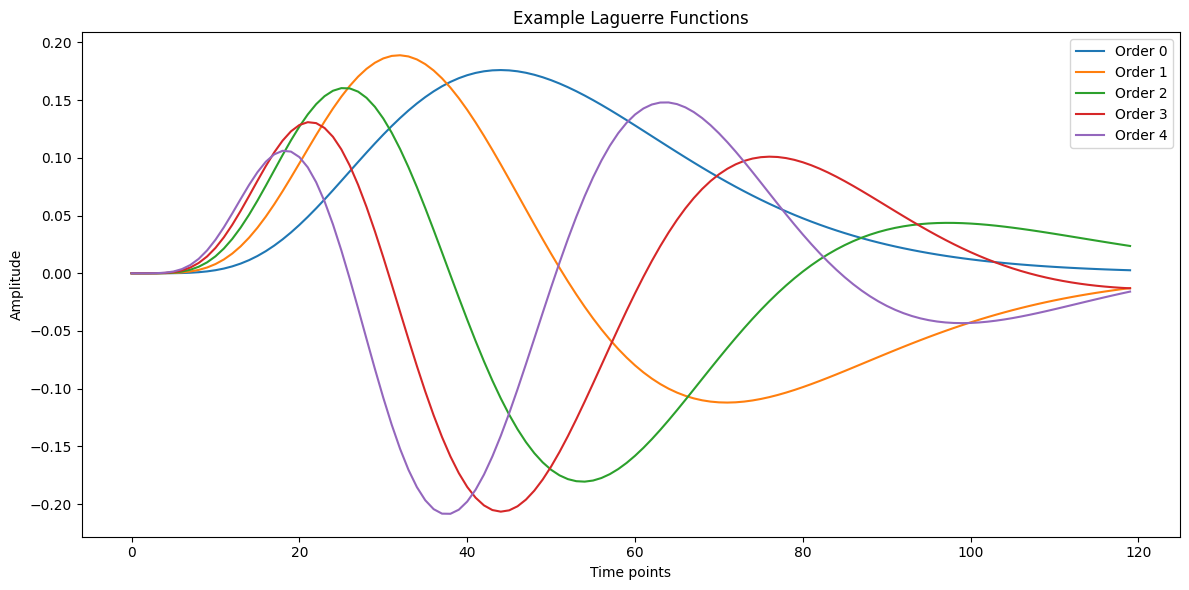

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]]


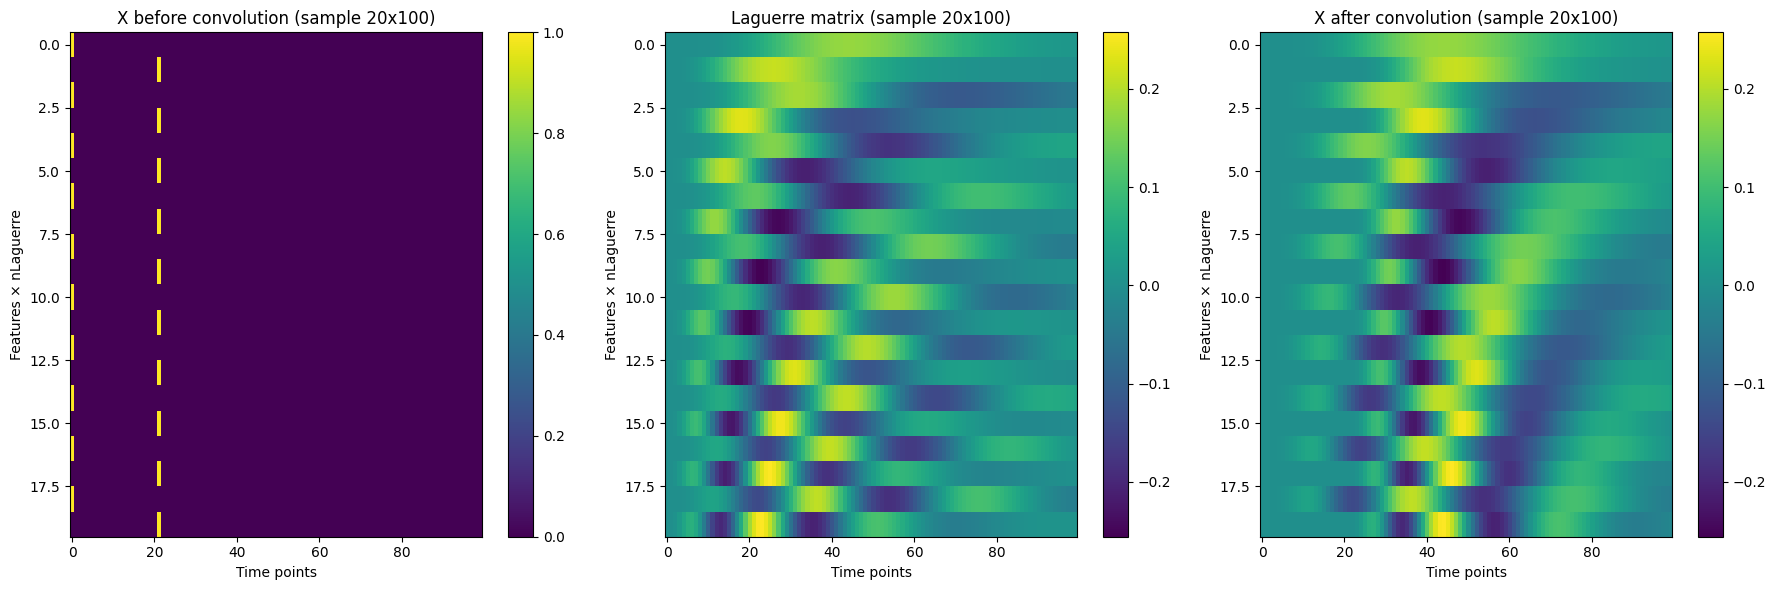

X before convolution shape: (20, 965)
Laguerre matrix shape: (20, 120)
X after convolution shape: (20, 965)


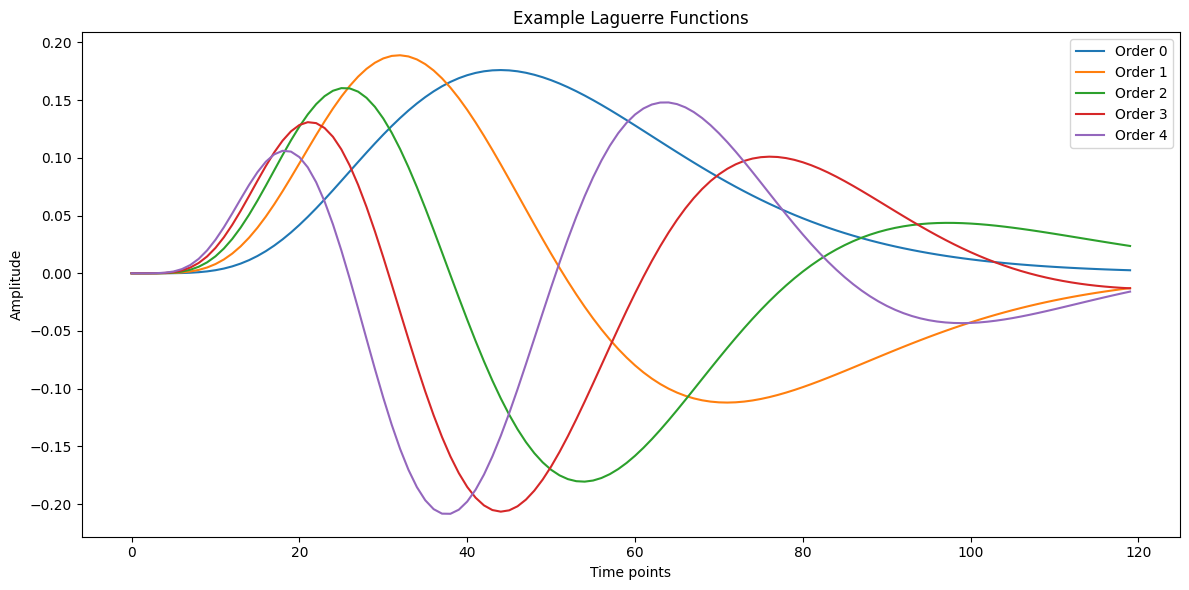

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


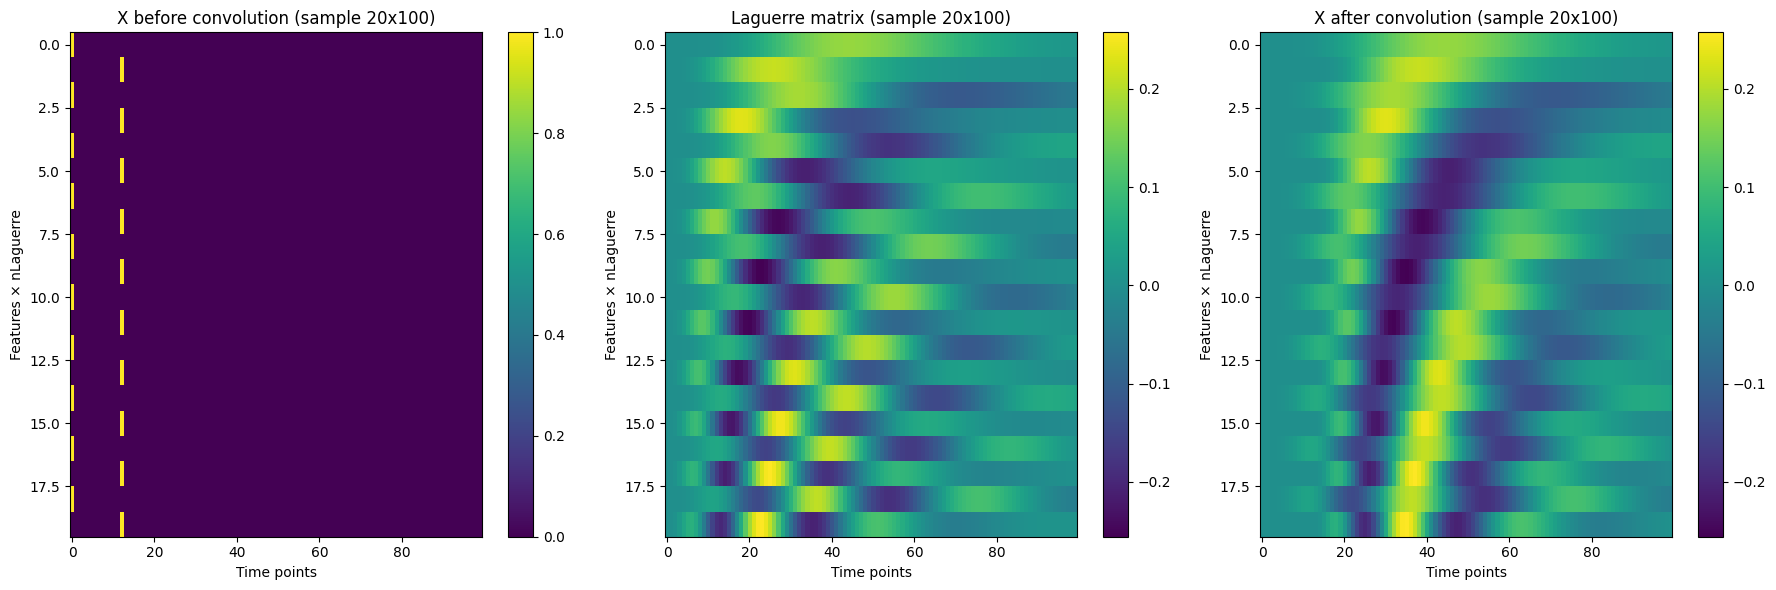

X before convolution shape: (20, 620)
Laguerre matrix shape: (20, 120)
X after convolution shape: (20, 620)


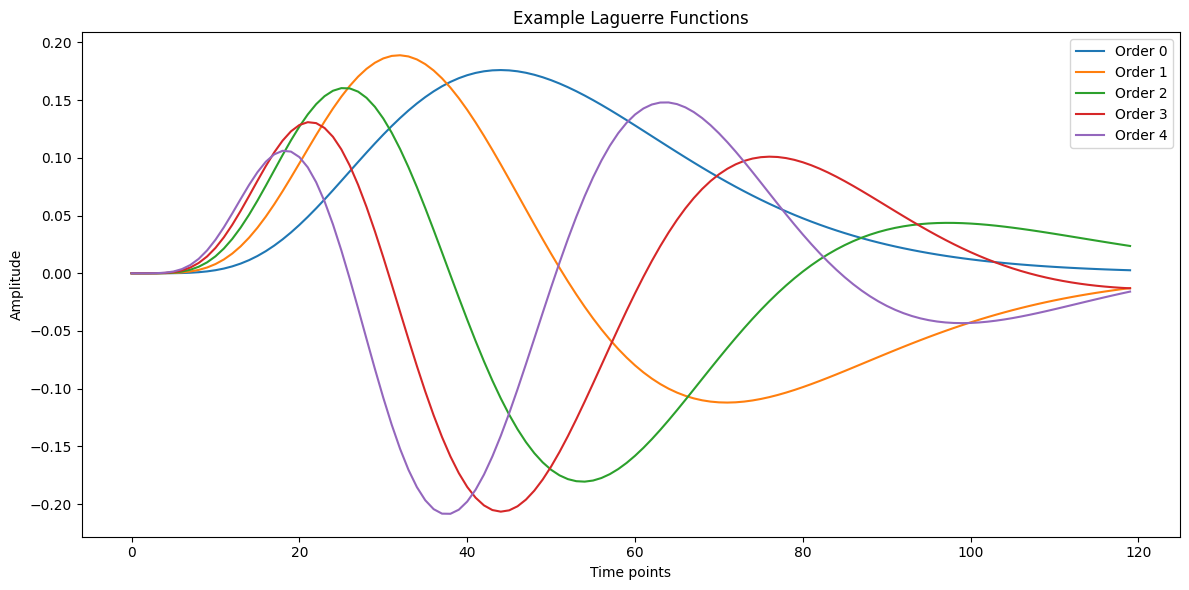

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]


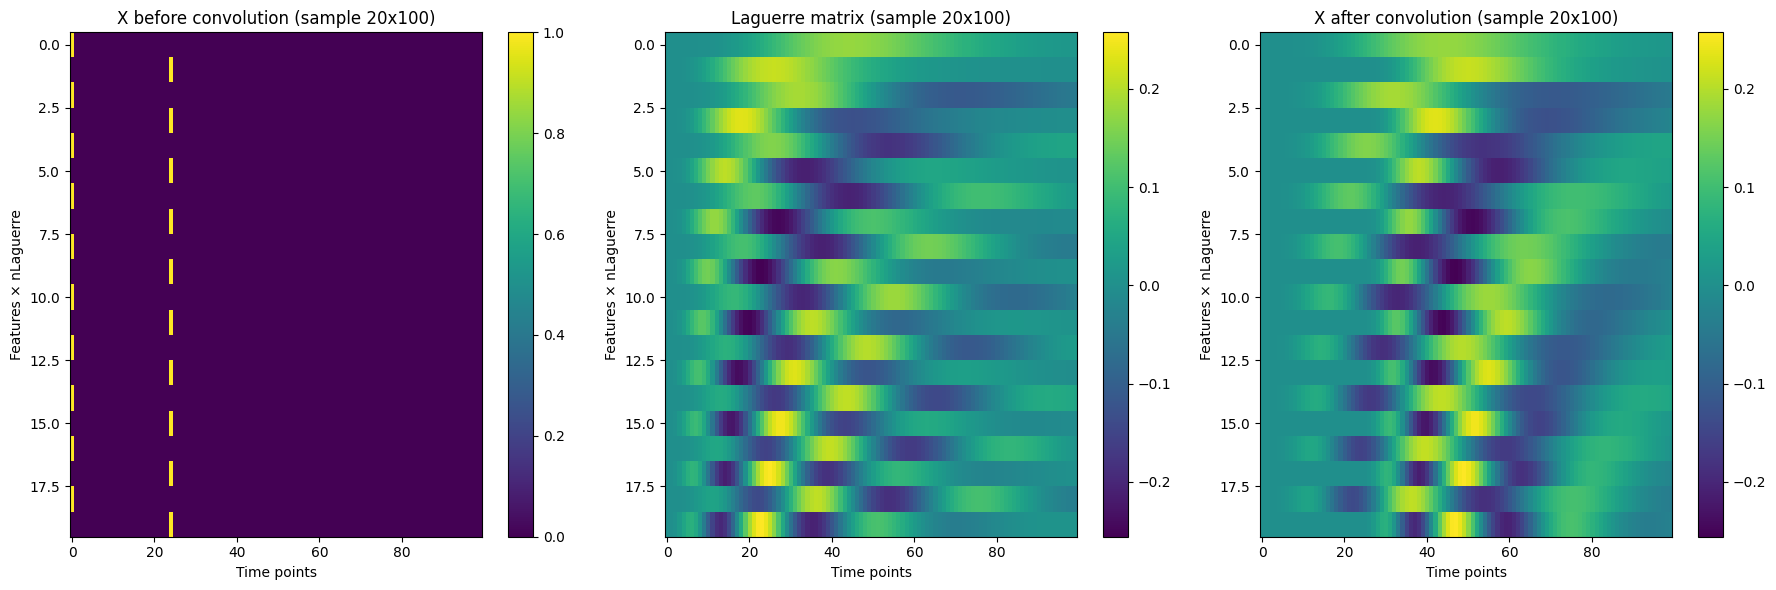

X before convolution shape: (20, 415)
Laguerre matrix shape: (20, 120)
X after convolution shape: (20, 415)


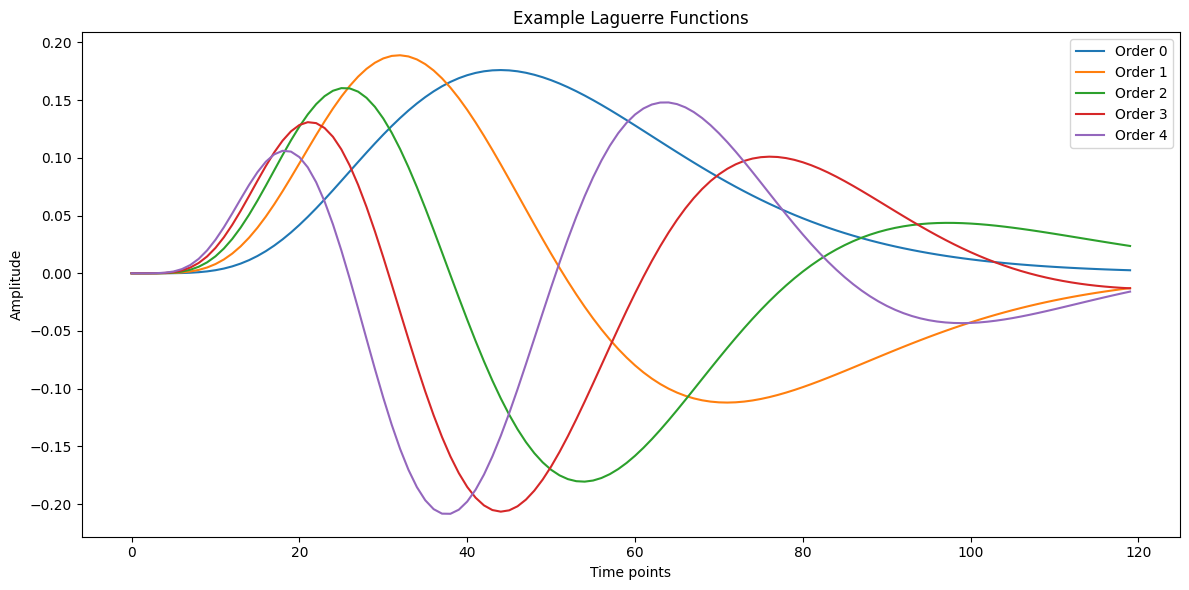

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


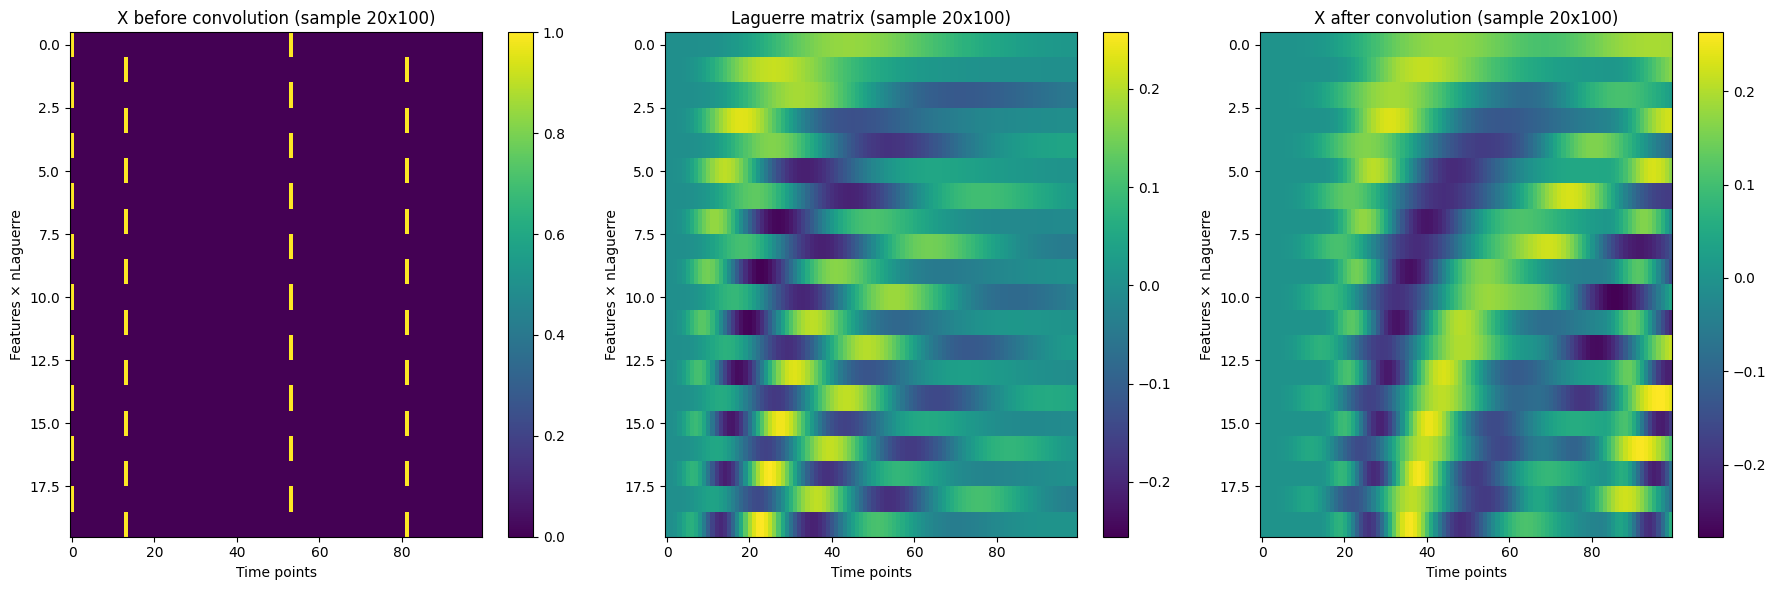

X before convolution shape: (20, 1003)
Laguerre matrix shape: (20, 120)
X after convolution shape: (20, 1003)


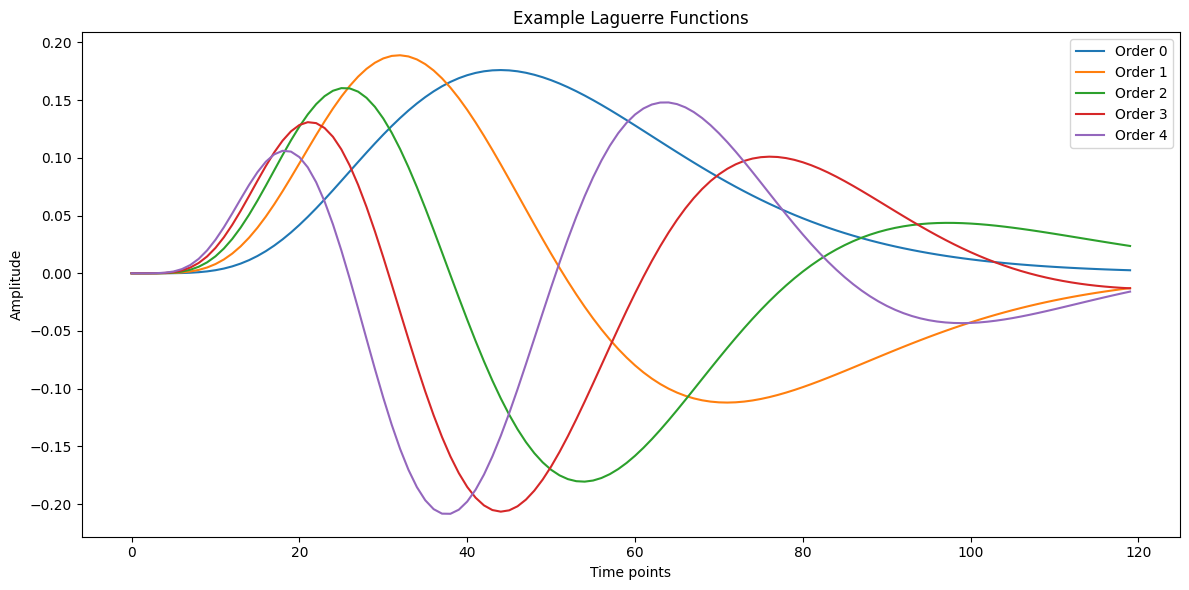

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


KeyboardInterrupt: 

In [34]:
from strfpy.calcSegmentedModel import generate_laguerre_features

Y_avg_removed = None
X = None
nLaguerre = 10
for feature_key in feature_keys:
    feature_x = None
    for k in train_data_dict.keys():
        pair = train_data_dict[k]
        print(pair['events'][feature_key])
        x = generate_laguerre_features(pair, feature_key, event_index_key='index_word-buffered', resp_key='lowpassed_downsampled_demeaned', laguerre_args = laguerre_args, nLaguerrePoints=nPoints, nLaguerre=nLaguerre, visualize=True)
        if feature_x is None:
            feature_x = x
        else:
            feature_x = np.hstack([feature_x, x])
    if X is None:
        X = feature_x
    else:
        X = np.vstack([X, feature_x])
        
for k in train_data_dict.keys():
    y = train_data_dict[k]['resp']['lowpassed_downsampled_demeaned']
    if Y_avg_removed is None:
        Y_avg_removed = y
    else:
        Y_avg_removed = np.hstack([Y_avg_removed, y])


In [30]:
X.shape, Y_avg_removed.shape

((140, 349839), (349839,))

In [31]:
start_idx = 0
transformations = []
sentence_position_keys = [key for key in feature_keys if key.startswith('sentence_position_')]

for i, event_key in enumerate(feature_keys):
    if event_key in train_data_dict[0]["events"].keys():
        # Get the shape for current event
        if len(train_data_dict[0]["events"][event_key].shape) == 1:
            current_shape = 1
        else:
            current_shape = train_data_dict[0]["events"][event_key].shape[1]
        
        if event_key.startswith('speaker_') or event_key.startswith('sentence_position_'):
            # Skip adding individual speaker keys
            continue
        
        # Create slice for this group, multiplied by nPoints
        end_idx = (start_idx + current_shape) * nLaguerre
        start_idx_scaled = start_idx * nLaguerre
        
        # Add transformation tuple for this group
        transformations.append((event_key, StandardScaler(), slice(start_idx_scaled, end_idx)))
        
        # Update start index for next group
        start_idx = start_idx + current_shape

if sentence_position_keys:
    start_idx_scaled = start_idx * nLaguerre
    end_idx = (start_idx + len(sentence_position_keys)*2) * nLaguerre
    transformations.append(('sentence_position_group', StandardScaler(), slice(start_idx_scaled, end_idx)))
    start_idx = start_idx + len(sentence_position_keys)*2
# Add a single group for all speaker keys
# if speaker_keys:
#     start_idx_scaled = start_idx * nLaguerre
#     end_idx = (start_idx + len(speaker_keys)*2) * nLaguerre
#     transformations.append(('speaker_group', StandardScaler(), slice(start_idx_scaled, end_idx)))

# Create the ColumnTransformerNoStack
ct = ColumnTransformerNoStack(transformations)

In [32]:
ct

ColumnTransformerNoStack(transformers=[('gpt2_surprisal', StandardScaler(),
                                        slice(0, 20, None)),
                                       ('sentence_position_group',
                                        StandardScaler(),
                                        slice(20, 140, None))])

In [33]:
X.shape

(140, 349839)

In [34]:
X = X.astype(np.float32)
Y_avg_removed = Y_avg_removed.astype(np.float32)
model = GroupRidgeCV(
    groups = 'input',
    solver_params={
        "n_iter": 100,
        "n_alphas_batch": 1,
    }
)
pipe = make_pipeline(ct, model)
pipe.fit(X.T, Y_avg_removed)

[........................................] 100% | 20.40 sec | 100 random sampling with cv | 


Pipeline(steps=[('columntransformernostack',
                 ColumnTransformerNoStack(transformers=[('gpt2_surprisal',
                                                         StandardScaler(),
                                                         slice(0, 20, None)),
                                                        ('sentence_position_group',
                                                         StandardScaler(),
                                                         slice(20, 140, None))])),
                ('groupridgecv',
                 GroupRidgeCV(groups='input',
                              solver_params={'n_alphas_batch': 1,
                                             'n_iter': 100}))])

In [35]:
from strfpy.calcSegmentedModel import generate_laguerre_features

Y_avg_removed_test = None
X_test = None
nLaguerre = 10
for feature_key in feature_keys:
    feature_x = None
    for k in test_data_dict.keys():
        pair = test_data_dict[k]
        x = generate_laguerre_features(pair, feature_key, event_index_key='index_word-buffered', resp_key='lowpassed_downsampled_demeaned', laguerre_args = laguerre_args, nLaguerrePoints=nPoints, nLaguerre=nLaguerre)
        if feature_x is None:
            feature_x = x
        else:
            feature_x = np.hstack([feature_x, x])
    if X_test is None:
        X_test = feature_x
    else:
        X_test = np.vstack([X_test, feature_x])
        
for k in test_data_dict.keys():
    y = test_data_dict[k]['resp']['lowpassed_downsampled_demeaned']
    if Y_avg_removed_test is None:
        Y_avg_removed_test = y
    else:
        Y_avg_removed_test = np.hstack([Y_avg_removed_test, y])




In [36]:
#Y_test_predict = pipe.predict(X_test.T)
R2 = pipe.score(X_test.T, Y_avg_removed_test)
R2

tensor(0.0608, device='cuda:0')

In [43]:
#Y_test_predict = pipe.predict(X_test.T)
R2 = pipe.score(X_test.T, Y_avg_removed_test)
R2

tensor(0.0724, device='cuda:0')

In [79]:
Y_avg_removed_test.shape

(81458,)

In [80]:
Y_test_pred_split.shape

torch.Size([7, 81458, 1])

In [81]:
Y_test_pred_split = pipe.predict(X_test.T, split=True)

In [82]:
Y_test_pred_split = Y_test_pred_split[:, :, np.newaxis]
Y_avg_removed_test = Y_avg_removed_test[:, np.newaxis]

In [83]:
split_scores = r2_score_split(Y_avg_removed_test, Y_test_pred_split)

In [84]:
split_scores

tensor([[ 4.8490e-10],
        [-3.0993e-04],
        [-9.1436e-03],
        [ 4.0965e-04],
        [ 2.8645e-05],
        [ 7.2710e-02],
        [ 6.6458e-04]], device='cuda:0', dtype=torch.float64)

In [ ]:
Y_test_pred_split = pipeline.predict(X_test, split=True)
split_scores_mask = r2_score_split(Y_test[:, mask], Y_test_pred_split)

print("(n_kernels, n_samples_test, n_voxels_mask) =", Y_test_pred_split.shape)
print("(n_kernels, n_voxels_mask) =", split_scores_mask.shape)

# extend to unfitted voxels
n_kernels = split_scores_mask.shape[0]
n_voxels = Y_train.shape[1]
split_scores = np.zeros((n_kernels, n_voxels))
split_scores[:, mask] = backend.to_numpy(split_scores_mask)
print("(n_kernels, n_voxels) =", split_scores.shape)

tensor(0.0673, device='cuda:0')

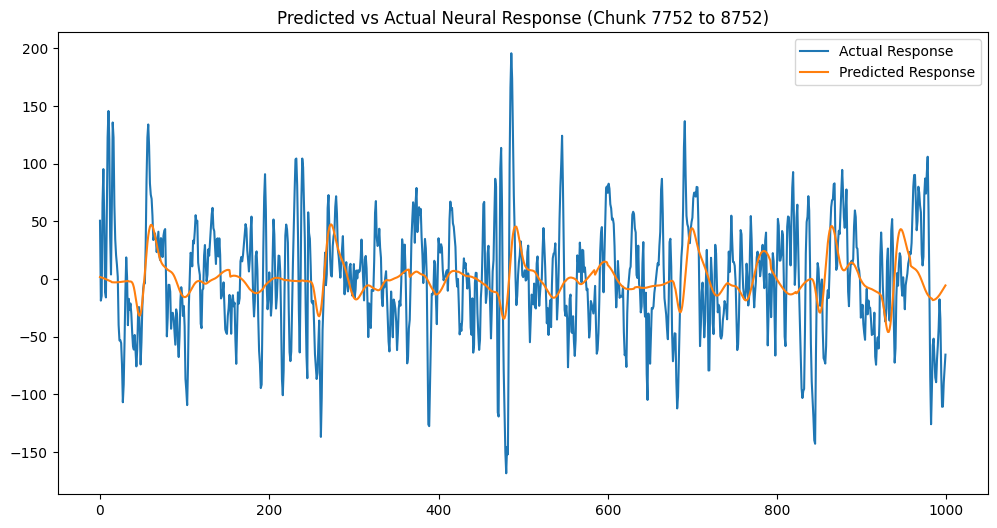

In [74]:
# Select random chunk from Y_avg_removed_test and Y_test_predict
plot_chunk_size = 1000
start_idx = np.random.randint(0, len(Y_avg_removed_test) - plot_chunk_size)
end_idx = start_idx + plot_chunk_size

# Extract the chunks
y_chunk = Y_avg_removed_test[start_idx:end_idx]
yhat_chunk = Y_test_predict[start_idx:end_idx]

# Plot the chunks
plt.figure(figsize=(12, 6))
plt.plot(y_chunk, label="Actual Response")
plt.plot(yhat_chunk, label="Predicted Response")
plt.legend()
plt.title(f"Predicted vs Actual Neural Response (Chunk {start_idx} to {end_idx})")
plt.show()